<a href="https://colab.research.google.com/github/550tealeaves/DATA-70500-working-with-data/blob/main/ORIG_TextAnalysisReddit2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identity Dynamics on Reddit

We'll look at how to implement the Reddit API to gather data from the platform.

BLOCK 1. Installing and loading relevant libraries.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
import requests # This is the library for embedding HTTP calls in the notebook
from random import sample
import scipy as sp
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances


In [ ]:
#asyncpraw works with Reddit API
!pip install asyncpraw
import asyncpraw as apw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 3.1 MB/s eta 0:00:00


In [ ]:
# Must use natural language tool-kit
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')    # This is a useful way to remove non-content function words from the data.
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
import string
import re

In [ ]:
# Contractions library will expand contractions before analysis
!pip install contractions
import contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.1 MB/s eta 0:00:00


In [ ]:
# wnl is the dictionary library for the coding
wnl = nltk.WordNetLemmatizer()
en_stop_words = set(nltk.corpus.stopwords.words('english'))


Block 2. Scraping Text as Data

Here we're using account credentials to access Reddit's API.

In [ ]:
# Make API request to Reddit using purchased credentials
reddit = apw.Reddit(
    client_id="Pxb331W3hgU59ZcQzkAhvA",
    client_secret="rMHz1irCS72aJuEzRpspOons78qkhA",
    user_agent="IdentityFormationWeb"
)

In [ ]:
# This helps find the subreddits about NFL, football, cowboys, combine, draft (anything listed in topics)
# Search through subreddits for the topics
# Use for loop to load subreddit & pick the 100 most popular posts
# Use async and await b/c not looping in real-time
# Create list (comments) that will have all the post IDs of the 100 popular posts  that you will use to scrape data
comments = []
topics = ["Christianity", "Evangelical", "Christian", "Pentecostal", "TrueChristian"]

for topic in topics:
    subreddit = await reddit.subreddit(topic)
    async for submission in subreddit.hot(limit=100):
        print(submission.id + ": " + submission.title)
        comments.append(submission.id)

print(len(comments))

1gh67lq: November Banner: World Children's Day
1gv9j6u: Archaeologists find first 'Jesus is God' inscription in Israeli prison, call it 'greatest discovery'
1gv57bo: The Story of Sodom and Gomorrah is Beyond Disturbing.
1guma9i: Last Sunday, I walked out of church during worship - what happened next changed everything
1gv5xgs: Texas signals support for Bible-infused curriculum
1gv35yq: Catholic League Rages Against "Pro-Abortion" RFK 
1guy3y2: Oklahoma Superintendent Demands Students Watch Him Pray for Trump
1guw79h: masturbation??
1guy5dz: How many young people here have actually read the Bible? 
1gv3q5o: How do I block porn permanently to avoid temptation and stay faithful?
1gv638p: Is there a reason God was visible and audible to the Israelites before Christ and now there’s just a blackout with just a church or scripture depending on what denomination you are? 
1gv9drr: “There is more grace in Christ, than sin in you”
1gv25kd: Why would be a 4 year old suicidal? 
1gv61bq: Earliest i

In [ ]:
# Has the lists of posts created in comments = []
#'Pagination error' - doesn't stop if it encounters an error
# Combine all posts into single corpus
discourse_comments = []

for item in comments:
    thread = await reddit.submission(item)

    try:
        for top_level_comment in thread.comments:
            discourse_comments.append(top_level_comment.body)

    except:
        print("Pagination error.")

print(len(discourse_comments))


3702


Block 3. Preparing the Data

In [ ]:
topic_corpus = []

for text in discourse_comments:
    texts = contractions.fix(text) # expand contractions
    sentences = nltk.sent_tokenize(texts) # break strings from sentences
    topic_paragraph = ''.join(sentences)
    topic_corpus.append(topic_paragraph)

print(len(topic_corpus))

3702


In [ ]:
wnl = nltk.WordNetLemmatizer()
tokens = [t.lower() for t in topic_corpus if t not in en_stop_words]
lemma = [wnl.lemmatize(t) for t in tokens]

print(len(lemma))

3700


In [ ]:
lemma2 = contractions.fix(str(lemma))
print(len(lemma2))

1732621


The vectorizer creates a document-token matrix, where each token is a variable (column) and each document is a case (row).

We convert it to a co-occurrence matrix in order to compute token distances: the more that tokens co-occur, the closer they are in the multidimensional scaling model that we will use to visualize the concept space of the corpus.

In [ ]:
# Produce document token matrix
vectorizer = CountVectorizer(
    #Set parameters
    min_df=0.03, #exclude words that occur <1% - don't hold analytical weight
    max_df=0.99, #exclude words that occur >99% - usually function words
    stop_words='english', # remove stop words
    ngram_range=(1,1) # ngram = token width - ngram(1,1) = single words - set to 2 or 3 to search for phrases
    )

topic_tm = vectorizer.fit_transform(lemma)

topic_feature_names = vectorizer.get_feature_names_out()

topic_dtm = pd.DataFrame(topic_tm.todense(), columns=topic_feature_names)
topic_dtm.head()

,10,actually,ask,away,bad,believe,best,better,bible,bless,...,used,want,wants,way,word,work,world,wrong,years,yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Filter out tokens w/o co-occurence of 1
# Create co-occurence matrix
# Use for loop to filter out nullwords (https, reddit, subreddit, copyright..)
# Create dataframe of tokens that co-occur once
topic_tokens_present = np.where(topic_dtm.max() > 0 , True, False)
topictokenslimited_df = topic_dtm.loc[:, topic_tokens_present]
nullwords = ["reddit", "subreddit", "copyright", "https", "http", "ve", "re", "10", "bot", "com", "www"]
for term in nullwords:
    topictokenslimited_df = topictokenslimited_df.drop(columns=[i for i in list(topictokenslimited_df.columns) if term in i])
topictokenslimited_df

,actually,ask,away,bad,best,better,bible,bless,body,book,...,used,want,wants,way,word,work,world,wrong,years,yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,0,0,0,0,1,0,0,0,0,0,...,0,0,0,4,0,0,1,0,0,0
3696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Create distance matrix
keyword_cofreq = topictokenslimited_df.T.dot(topictokenslimited_df)
keyword_dist = 1/(keyword_cofreq + 1)
keyword_dist  # distance matrix

,actually,ask,away,bad,best,better,bible,bless,body,book,...,used,want,wants,way,word,work,world,wrong,years,yes
actually,0.004587,0.055556,0.030303,0.041667,0.045455,0.041667,0.012048,0.083333,0.050000,0.033333,...,0.045455,0.014085,0.052632,0.011494,0.026316,0.041667,0.031250,0.050000,0.020833,0.066667
ask,0.055556,0.002494,0.021277,0.062500,0.038462,0.034483,0.006173,0.030303,0.019608,0.032258,...,0.071429,0.009615,0.025000,0.014085,0.012500,0.027778,0.019231,0.090909,0.021277,0.038462
away,0.030303,0.021277,0.002203,0.021739,0.018182,0.017857,0.006944,0.035714,0.016949,0.024390,...,0.047619,0.009524,0.021739,0.005556,0.013699,0.033333,0.013158,0.031250,0.014706,0.062500
bad,0.041667,0.062500,0.021739,0.004464,0.023810,0.040000,0.013514,0.200000,0.142857,0.047619,...,0.050000,0.017544,0.052632,0.013333,0.028571,0.028571,0.033333,0.038462,0.020408,0.111111
best,0.045455,0.038462,0.018182,0.023810,0.004525,0.034483,0.010000,0.058824,0.050000,0.023810,...,0.062500,0.020408,0.062500,0.010870,0.050000,0.043478,0.017544,0.055556,0.023256,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
work,0.041667,0.027778,0.033333,0.028571,0.043478,0.030303,0.008929,0.037037,0.041667,0.047619,...,0.035714,0.011494,0.040000,0.008065,0.030303,0.002841,0.016949,0.045455,0.010989,0.038462
world,0.031250,0.019231,0.013158,0.033333,0.017544,0.029412,0.005155,0.026316,0.024390,0.019231,...,0.041667,0.011111,0.025641,0.007812,0.010000,0.016949,0.001565,0.031250,0.014706,0.026316
wrong,0.050000,0.090909,0.031250,0.038462,0.055556,0.058824,0.012987,0.090909,0.047619,0.062500,...,0.045455,0.013333,0.090909,0.012346,0.024390,0.045455,0.031250,0.004525,0.027778,0.058824
years,0.020833,0.021277,0.014706,0.020408,0.023256,0.029412,0.004184,0.041667,0.083333,0.024390,...,0.031250,0.011628,0.022222,0.005650,0.016949,0.010989,0.014706,0.027778,0.001715,0.045455


BLOCK 4. Analysis and visualization.

In [ ]:
# Multidimensional scaling - uses Euclidean space and PCA to arrange tokesn in specific space
mds = MDS(metric=False, n_components = 2, random_state=0, dissimilarity='precomputed')
pca = PCA(n_components=2)
keywords_transform = mds.fit_transform(keyword_dist)
print(keywords_transform)
print(mds.stress_)

[[ 0.04121733  0.30312587]
 [ 0.09724133  0.07187675]
 [-0.11175179  0.19574562]
 [-0.04530028  0.41763284]
 [ 0.48290556 -0.10994296]
 [ 0.32681614  0.05904815]
 [ 0.05257295  0.43363444]
 [-0.42941738 -0.36062008]
 [-0.44206213  0.27660125]
 [ 0.2550743   0.38677421]
 [ 0.42081838  0.30836574]
 [-0.03473479  0.33840243]
 [-0.41902942  0.1134153 ]
 [-0.30369096  0.39021645]
 [-0.03992421 -0.07601282]
 [-0.23705715  0.30275911]
 [-0.09833216  0.1124941 ]
 [-0.48565144  0.08866948]
 [ 0.11309626  0.20377592]
 [ 0.44697922  0.21991781]
 [-0.19376695 -0.0284939 ]
 [ 0.18430402 -0.50156233]
 [ 0.17296434  0.25798222]
 [-0.3471562  -0.40596582]
 [-0.2442318  -0.12542991]
 [ 0.00721767 -0.02483253]
 [ 0.50489516 -0.37103769]
 [-0.35756817 -0.34716658]
 [ 0.13222668 -0.27518904]
 [-0.09928512 -0.26216664]
 [-0.38829391 -0.39445082]
 [ 0.13710647 -0.41362334]
 [-0.35622949 -0.12775217]
 [ 0.35794646 -0.42307391]
 [ 0.38715466 -0.4191464 ]
 [ 0.54912117 -0.03382369]
 [ 0.54325971  0.11615014]
 

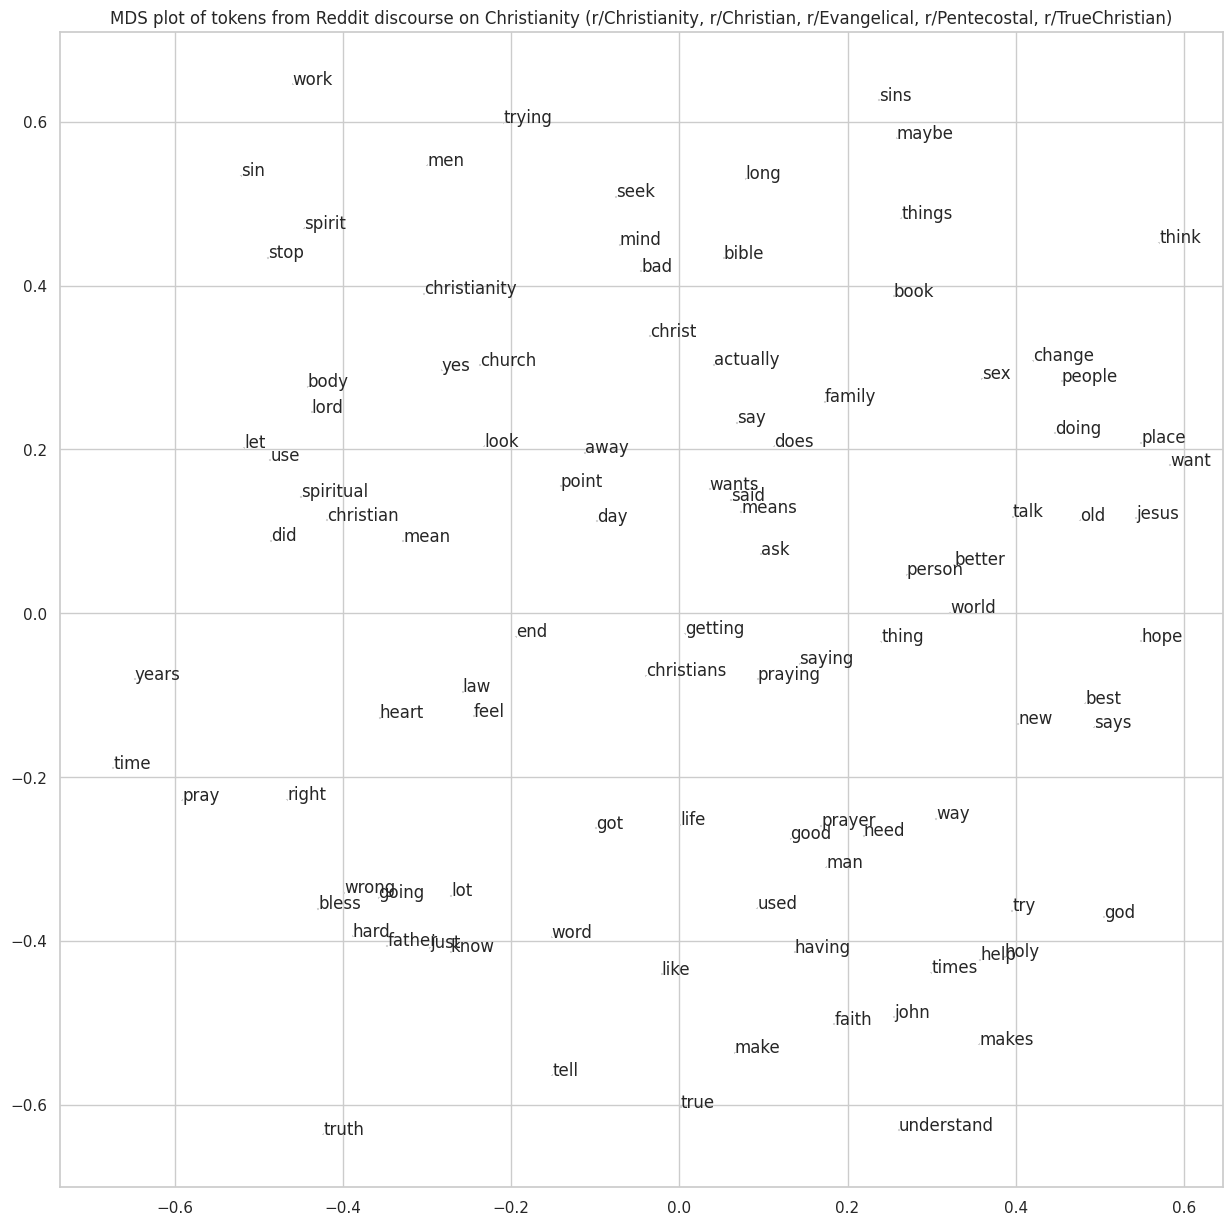

In [ ]:
# Plots graph using seaborn and matplotlib libraries
# Words that are close together co-occured more frequently
## Get a sense of what ppl are discussing on subreddits
### Does it help us understand how Christians describe themselves?
# Numbers on axes don't really matter
sb.set_theme(style="whitegrid")
fig = plt.figure(figsize=(15,15))
i = 0
while i < len(topictokenslimited_df.columns):
    plt.scatter(keywords_transform[i,0], keywords_transform[i,1], sizes=(1, 1), marker='+', c='lightgrey')
    plt.text(keywords_transform[i,0], keywords_transform[i,1], topictokenslimited_df.columns[i])
    i += 1
plt.title('MDS plot of tokens from Reddit discourse on Christianity (r/Christianity, r/Christian, r/Evangelical, r/Pentecostal, r/TrueChristian)')
plt.show()